## Actor-Critic implementation 

In [1]:
import sys

sys.path.append("../src")

%load_ext autoreload
%autoreload 2

In [11]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using device: {device}")

Using device: mps


In [12]:
# Import necessary libraries

import random
import time
from collections import deque
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.autograd import Variable
from torch.distributions import Categorical

from itertools import count
import seaborn as sns
import shutil

import matplotlib.pyplot as plt

import cv2
import imageio

from utils import create_env, show
from base_agent import BaseAgent
from replay_memory import ReplayMemory, Transition
from summary_writer import LocalSummaryWriter

In [13]:
class ActorNetwork(nn.Module):
    """Actor Network for the policy gradient method."""

    def __init__(self, state_size, action_size):
        super(ActorNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        """Forward pass through the network."""
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


In [14]:
class CriticNetwork(nn.Module):
    """Critic Network for Policy Gradient."""

    # The critic network is used to estimate the value function.
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        """Forward pass through the network."""
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [23]:
"""Actor and Critic Networks for the A2C algorithm."""


class A2CAgent(BaseAgent):
    """Agent class for the Actor-Critic algorithm."""

    def __init__(
        self,
        env: gym.Env,
        gamma=0.99,
        lr=5e-4,
        buffer_size=int(1e5),
        batch_size=100,
        learn_every=4,
        writer=None,
    ):
        super(A2CAgent, self).__init__(env=env)
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.shape[0]
        self.learn_every = learn_every
        self.batch_size = batch_size
        self.gamma = gamma
        self.actor = ActorNetwork(self.state_size, self.action_size).to(device)
        self.critic = CriticNetwork(self.state_size, self.action_size).to(device)
        self.optimizerA = optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizerC = optim.Adam(self.critic.parameters(), lr=lr)
        self.memory = ReplayMemory(buffer_size)
        self.learn_step = 0
        self.writer = writer
        self.plots = {"Loss": [], "Epsilon": [], "Reward": [], "Mean Reward": []}

    def compute_returns(self, next_value, rewards, masks, gamma=0.99):
        """Compute the returns for the given rewards and masks."""
        R = next_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + gamma * R * masks[step]
            returns.insert(0, R)
        return returns

    def act(self, state):
        """Select an action based on the current state."""
        logits = self.actor(state)
        dist = Categorical(logits=logits)
        action = dist.sample()

        return action.item(), dist.log_prob(action)

    def step(self, action: int) -> tuple[int, any, Tensor, bool, bool]:
        """Take a step in the environment."""
        state, reward, done, terminated, _ = self.env.step(action)
        return (
            state,
            reward,
            done,
            terminated,
        )

    def optimize(self):
        """Sample a batch of experiences and update the actor and critic networks."""
        pass

    # Training loop
    def train(self, num_episodes=500, smooth=100):
        """Train the agent."""
        smoothed_reward = []
        raw_reward = []
        elapsed_times = []
        mean_reward = 0
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            log_probs = []
            values = []
            rewards = []
            masks = []
            entropy = 0
            total_reward = 0
            start_time = time.time()

            for i in count():
                state = torch.FloatTensor(state).to(device)
                dist, q_value = self.actor(state), self.critic(state)

                action = dist.sample()
                next_state, reward, done, terminate, _ = self.env.step(action.cpu().numpy())
                done = done or terminate

                log_prob = dist.log_prob(action).unsqueeze(0)
                entropy += dist.entropy().mean()

                log_probs.append(log_prob)
                values.append(q_value)
                rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
                masks.append(torch.tensor([1 - done], dtype=torch.float, device=device))
                total_reward += reward
                state = next_state
                end_time = time.time()
                if done or terminate:
                    elapsed_time = end_time - start_time
                    # print("Iteration: {}, Score: {}".format(episode, i))
                    break

            next_state = torch.FloatTensor(next_state).to(device)
            next_value = self.critic(next_state)
            returns = self.compute_returns(next_value, rewards, masks, self.gamma)

            log_probs = torch.cat(log_probs)
            returns = torch.cat(returns).detach()
            values = torch.cat(values)

            advantage = returns - values

            actor_loss = -(log_probs * advantage.detach()).mean()
            critic_loss = advantage.pow(2).mean()

            self.optimizerA.zero_grad()
            self.optimizerC.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.optimizerA.step()
            self.optimizerC.step()

            elapsed_times.append(elapsed_time)
            raw_reward.append(total_reward)
            smoothed_reward.append(total_reward)
            if len(smoothed_reward) > smooth:
                smoothed_reward = smoothed_reward[-1 * smooth : -1]

            mean_reward = np.mean(smoothed_reward)

            self.writer.add_scalar("Reward", total_reward, episode)
            self.writer.add_scalar("Mean Reward", np.mean(smoothed_reward), episode)

            self.plots["Reward"].append(total_reward)
            self.plots["Mean Reward"].append(mean_reward)

            if episode % 100 == 0:
                print(
                    "\tEpisode {} \t Final Reward {:.2f} \t Average Reward: {:.2f}".format(
                        episode, total_reward, np.mean(smoothed_reward)
                    )
                )

        print(
            "\tEpisode {} \t Final Reward {:.2f} \t Average Reward: {:.2f}".format(
                num_episodes, total_reward, np.mean(smoothed_reward)
            )
        )
        return elapsed_times, raw_reward, smoothed_reward

    def run(self, episodes=100):
        """Run/test the agent in the environment."""
        frames = []
        rewards = 0

        self.load()

        state = self.env.reset()[0]
        state = Variable(torch.from_numpy(state).float().unsqueeze(0)).to(device)
        done = False
        i = 0
        while not done:
            frame = self.env.render()
            frames.append(frame)

            dist = self.actor(state)
            action = dist.sample()
            next_state, reward, done, terminated, _ = self.env.step(action.item())
            state = Variable(torch.from_numpy(next_state).float().unsqueeze(0)).to(device)
            rewards += reward
            i += 1
            if done or terminated:
                print("Score: {} in {} steps".format(rewards, i))
                break

        print("\tTotal Reward: ", rewards)
        print("\tSaving Animation ...")

        video_path = "%s/cartpole-movie.mp4" % self.writer.log_dir
        fps = 30
        imageio.mimsave(video_path, frames, fps=fps)

        video = cv2.VideoCapture(video_path)

        frame_per_second = video.get(cv2.CAP_PROP_FPS)
        assert frame_per_second == fps, f"FPS should be {fps} but got {frame_per_second}"
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

        return frame_count / frame_per_second if frame_per_second > 0 else 0, rewards

    def plot(self):
        """Plot the training results."""
        sns.set()
        sns.set_context("poster")

        plt.figure(figsize=(20, 16))
        plt.plot(np.arange(len(self.plots["Reward"])), self.plots["Reward"], label="Reward")
        plt.plot(
            np.arange(len(self.plots["Mean Reward"])),
            self.plots["Mean Reward"],
            label="Mean Reward",
        )
        plt.legend()
        plt.title("ACM Gradient Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.savefig("%s/plot_%s.png" % (self.writer.log_dir, "rewards"))

    def save(self):
        """Save the model."""
        torch.save(self.actor.state_dict(), "%s/model.pt" % self.writer.log_dir)

    def load(self):
        """Load the model."""
        self.actor.load_state_dict(torch.load("%s/model.pt" % self.writer.log_dir))
        self.actor.eval()

In [24]:
def main():
    """Train and Run the DQN agent."""
    HYPERPARAMS = {
        "env_name": "CartPole-v1",
        "number_of_experiments": 50,
        "num_episodes": 1000,
        "lr": 1e-4,
        "eps_start": 0.999,
        "eps_end": 0.01,
        "eps_decay": 0.999,
        "gamma": 0.93,
        "batch_size": 32,
        "learn_every": 4,
        "random_seed": 42,
    }

    torch.manual_seed(HYPERPARAMS["random_seed"])
    np.random.seed(HYPERPARAMS["random_seed"])
    random.seed(HYPERPARAMS["random_seed"])

    rewards = []
    run_times = []
    for i in range(1, HYPERPARAMS["number_of_experiments"] + 1):
        print("[Experiment]\t{} of {}".format(i, HYPERPARAMS["number_of_experiments"]))

        if i == 1:
            path = f"../experiments/a2c_cartpole/run-{i}"
            shutil.rmtree(path, ignore_errors=True)

            writer = LocalSummaryWriter(path)
            writer.add_parameters(HYPERPARAMS)

            env, _, _ = create_env(HYPERPARAMS["env_name"])
            env.reset()

            runner = A2CAgent(
                env,
                batch_size=HYPERPARAMS["batch_size"],
                lr=HYPERPARAMS["lr"],
                gamma=HYPERPARAMS["gamma"],
                learn_every=HYPERPARAMS["learn_every"],
                writer=writer,
            )

            print("[Train]\tTraining Beginning ...")
            train_times, train_rewards, _ = runner.train(HYPERPARAMS["num_episodes"])

            print("[Plot]\tPlotting Training Curves ...")
            runner.plot()

            print("[Save]\tSaving Model ...")
            runner.save()

        print("[Run]\tRunning Simulation ...")
        run_time, reward = runner.run()
        rewards.append(reward)
        run_times.append(run_time)

        print("[Video]\tShow Video ...")
        video_path = "%s/cartpole-movie.mp4" % path
        show(video_path)

    print("[End]\tDone. Congratulations!")

    print("[Reward]\tAverage Reward: ", np.mean(rewards))
    print("[Reward]\tStandard Deviation of Reward: ", np.std(rewards))
    print("[Reward]\tMax Reward: ", np.max(rewards))
    print("[Reward]\tMin Reward: ", np.min(rewards))

    print("[RunTime]\tAverage Run Time: ", np.mean(run_times))
    print("[RunTime]\tStandard Deviation of Run Time: ", np.std(run_times))
    print("[RunTime]\tMax Run Time: ", np.max(run_times))
    print("[RunTime]\tMin Run Time: ", np.min(run_times))

    print("[TrainingTime]\tAverage Training Time: ", np.mean(train_times))
    print("[TrainingTime]\tMax Training Time: ", np.max(train_times))
    print("[TrainingTime]\tMin Training Time: ", np.min(train_times))

    print("[TrainingReward]\tAverage Training Reward: ", np.mean(train_rewards))
    print("[TrainingReward]\tMax Training Rewards: ", np.max(train_rewards))
    print("[TrainingReward]\tMin Training Rewards: ", np.min(train_rewards))

[Experiment]	1 of 50
State Shape : (4,)
State Size : 4
Number of Actions : 2
[Train]	Training Beginning ...
	Episode 0 	 Final Reward 36.00 	 Average Reward: 36.00
	Episode 100 	 Final Reward 44.00 	 Average Reward: 22.65
	Episode 200 	 Final Reward 20.00 	 Average Reward: 25.06
	Episode 300 	 Final Reward 57.00 	 Average Reward: 26.98
	Episode 400 	 Final Reward 127.00 	 Average Reward: 31.14
	Episode 500 	 Final Reward 41.00 	 Average Reward: 45.71
	Episode 600 	 Final Reward 156.00 	 Average Reward: 79.16
	Episode 700 	 Final Reward 206.00 	 Average Reward: 126.79
	Episode 800 	 Final Reward 19.00 	 Average Reward: 154.35
	Episode 900 	 Final Reward 171.00 	 Average Reward: 191.21
	Episode 1000 	 Final Reward 40.00 	 Average Reward: 242.87
[Plot]	Plotting Training Curves ...
[Save]	Saving Model ...
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 175.0 in 175 steps
	Total Reward:  175.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=175.0
duration=5.833333333333333
[Experiment]	2 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 106.0 in 106 steps
	Total Reward:  106.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=106.0
duration=3.533333333333333
[Experiment]	3 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 134.0 in 134 steps
	Total Reward:  134.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=134.0
duration=4.466666666666667
[Experiment]	4 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 254.0 in 254 steps
	Total Reward:  254.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=254.0
duration=8.466666666666667
[Experiment]	5 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 176.0 in 176 steps
	Total Reward:  176.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=176.0
duration=5.866666666666666
[Experiment]	6 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 294.0 in 294 steps
	Total Reward:  294.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=294.0
duration=9.8
[Experiment]	7 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 293.0 in 293 steps
	Total Reward:  293.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=293.0
duration=9.766666666666667
[Experiment]	8 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 500.0 in 500 steps
	Total Reward:  500.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=500.0
duration=16.666666666666668
[Experiment]	9 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 253.0 in 253 steps
	Total Reward:  253.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=253.0
duration=8.433333333333334
[Experiment]	10 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 203.0 in 203 steps
	Total Reward:  203.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=203.0
duration=6.766666666666667
[Experiment]	11 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 186.0 in 186 steps
	Total Reward:  186.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=186.0
duration=6.2
[Experiment]	12 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 67.0 in 67 steps
	Total Reward:  67.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=67.0
duration=2.2333333333333334
[Experiment]	13 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 500.0 in 500 steps
	Total Reward:  500.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=500.0
duration=16.666666666666668
[Experiment]	14 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 393.0 in 393 steps
	Total Reward:  393.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=393.0
duration=13.1
[Experiment]	15 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 245.0 in 245 steps
	Total Reward:  245.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=245.0
duration=8.166666666666666
[Experiment]	16 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 176.0 in 176 steps
	Total Reward:  176.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=176.0
duration=5.866666666666666
[Experiment]	17 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 90.0 in 90 steps
	Total Reward:  90.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=90.0
duration=3.0
[Experiment]	18 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 146.0 in 146 steps
	Total Reward:  146.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=146.0
duration=4.866666666666666
[Experiment]	19 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 299.0 in 299 steps
	Total Reward:  299.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=299.0
duration=9.966666666666667
[Experiment]	20 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 294.0 in 294 steps
	Total Reward:  294.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=294.0
duration=9.8
[Experiment]	21 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 500.0 in 500 steps
	Total Reward:  500.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=500.0
duration=16.666666666666668
[Experiment]	22 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 271.0 in 271 steps
	Total Reward:  271.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=271.0
duration=9.033333333333333
[Experiment]	23 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 305.0 in 305 steps
	Total Reward:  305.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=305.0
duration=10.166666666666666
[Experiment]	24 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 350.0 in 350 steps
	Total Reward:  350.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=350.0
duration=11.666666666666666
[Experiment]	25 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 224.0 in 224 steps
	Total Reward:  224.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=224.0
duration=7.466666666666667
[Experiment]	26 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 257.0 in 257 steps
	Total Reward:  257.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=257.0
duration=8.566666666666666
[Experiment]	27 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 234.0 in 234 steps
	Total Reward:  234.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=234.0
duration=7.8
[Experiment]	28 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 337.0 in 337 steps
	Total Reward:  337.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=337.0
duration=11.233333333333333
[Experiment]	29 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 479.0 in 479 steps
	Total Reward:  479.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=479.0
duration=15.966666666666667
[Experiment]	30 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 236.0 in 236 steps
	Total Reward:  236.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=236.0
duration=7.866666666666666
[Experiment]	31 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 193.0 in 193 steps
	Total Reward:  193.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=193.0
duration=6.433333333333334
[Experiment]	32 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 367.0 in 367 steps
	Total Reward:  367.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=367.0
duration=12.233333333333333
[Experiment]	33 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 227.0 in 227 steps
	Total Reward:  227.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=227.0
duration=7.566666666666666
[Experiment]	34 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 401.0 in 401 steps
	Total Reward:  401.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=401.0
duration=13.366666666666667
[Experiment]	35 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 238.0 in 238 steps
	Total Reward:  238.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=238.0
duration=7.933333333333334
[Experiment]	36 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 230.0 in 230 steps
	Total Reward:  230.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=230.0
duration=7.666666666666667
[Experiment]	37 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 165.0 in 165 steps
	Total Reward:  165.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=165.0
duration=5.5
[Experiment]	38 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 218.0 in 218 steps
	Total Reward:  218.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=218.0
duration=7.266666666666667
[Experiment]	39 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 144.0 in 144 steps
	Total Reward:  144.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=144.0
duration=4.8
[Experiment]	40 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 261.0 in 261 steps
	Total Reward:  261.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=261.0
duration=8.7
[Experiment]	41 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 208.0 in 208 steps
	Total Reward:  208.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=208.0
duration=6.933333333333334
[Experiment]	42 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 345.0 in 345 steps
	Total Reward:  345.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=345.0
duration=11.5
[Experiment]	43 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 147.0 in 147 steps
	Total Reward:  147.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=147.0
duration=4.9
[Experiment]	44 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 267.0 in 267 steps
	Total Reward:  267.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=267.0
duration=8.9
[Experiment]	45 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 401.0 in 401 steps
	Total Reward:  401.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=401.0
duration=13.366666666666667
[Experiment]	46 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 229.0 in 229 steps
	Total Reward:  229.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=229.0
duration=7.633333333333334
[Experiment]	47 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 190.0 in 190 steps
	Total Reward:  190.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=190.0
duration=6.333333333333333
[Experiment]	48 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 294.0 in 294 steps
	Total Reward:  294.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=294.0
duration=9.8
[Experiment]	49 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 259.0 in 259 steps
	Total Reward:  259.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=259.0
duration=8.633333333333333
[Experiment]	50 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 330.0 in 330 steps
	Total Reward:  330.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=330.0
duration=11.0
[End]	Done. Congratulations!
[Reward]	Average Reward:  261.82
[Reward]	Standard Deviation of Reward:  102.7746447330274
[Reward]	Max Reward:  500.0
[Reward]	Min Reward:  67.0
[RunTime]	Average Run Time:  8.727333333333334
[RunTime]	Standard Deviation of Run Time:  3.425821491100914
[RunTime]	Max Run Time:  16.666666666666668
[RunTime]	Min Run Time:  2.2333333333333334
[TrainingTime]	Average Training Time:  0.37988341903686523
[TrainingTime]	Max Training Time:  1.8491649627685547
[TrainingTime]	Min Training Time:  0.032118797302246094
[TrainingReward]	Average Training Reward:  102.979
[TrainingReward]	Max Training Rewards:  500.0
[TrainingReward]	Min Training Rewards:  9.0


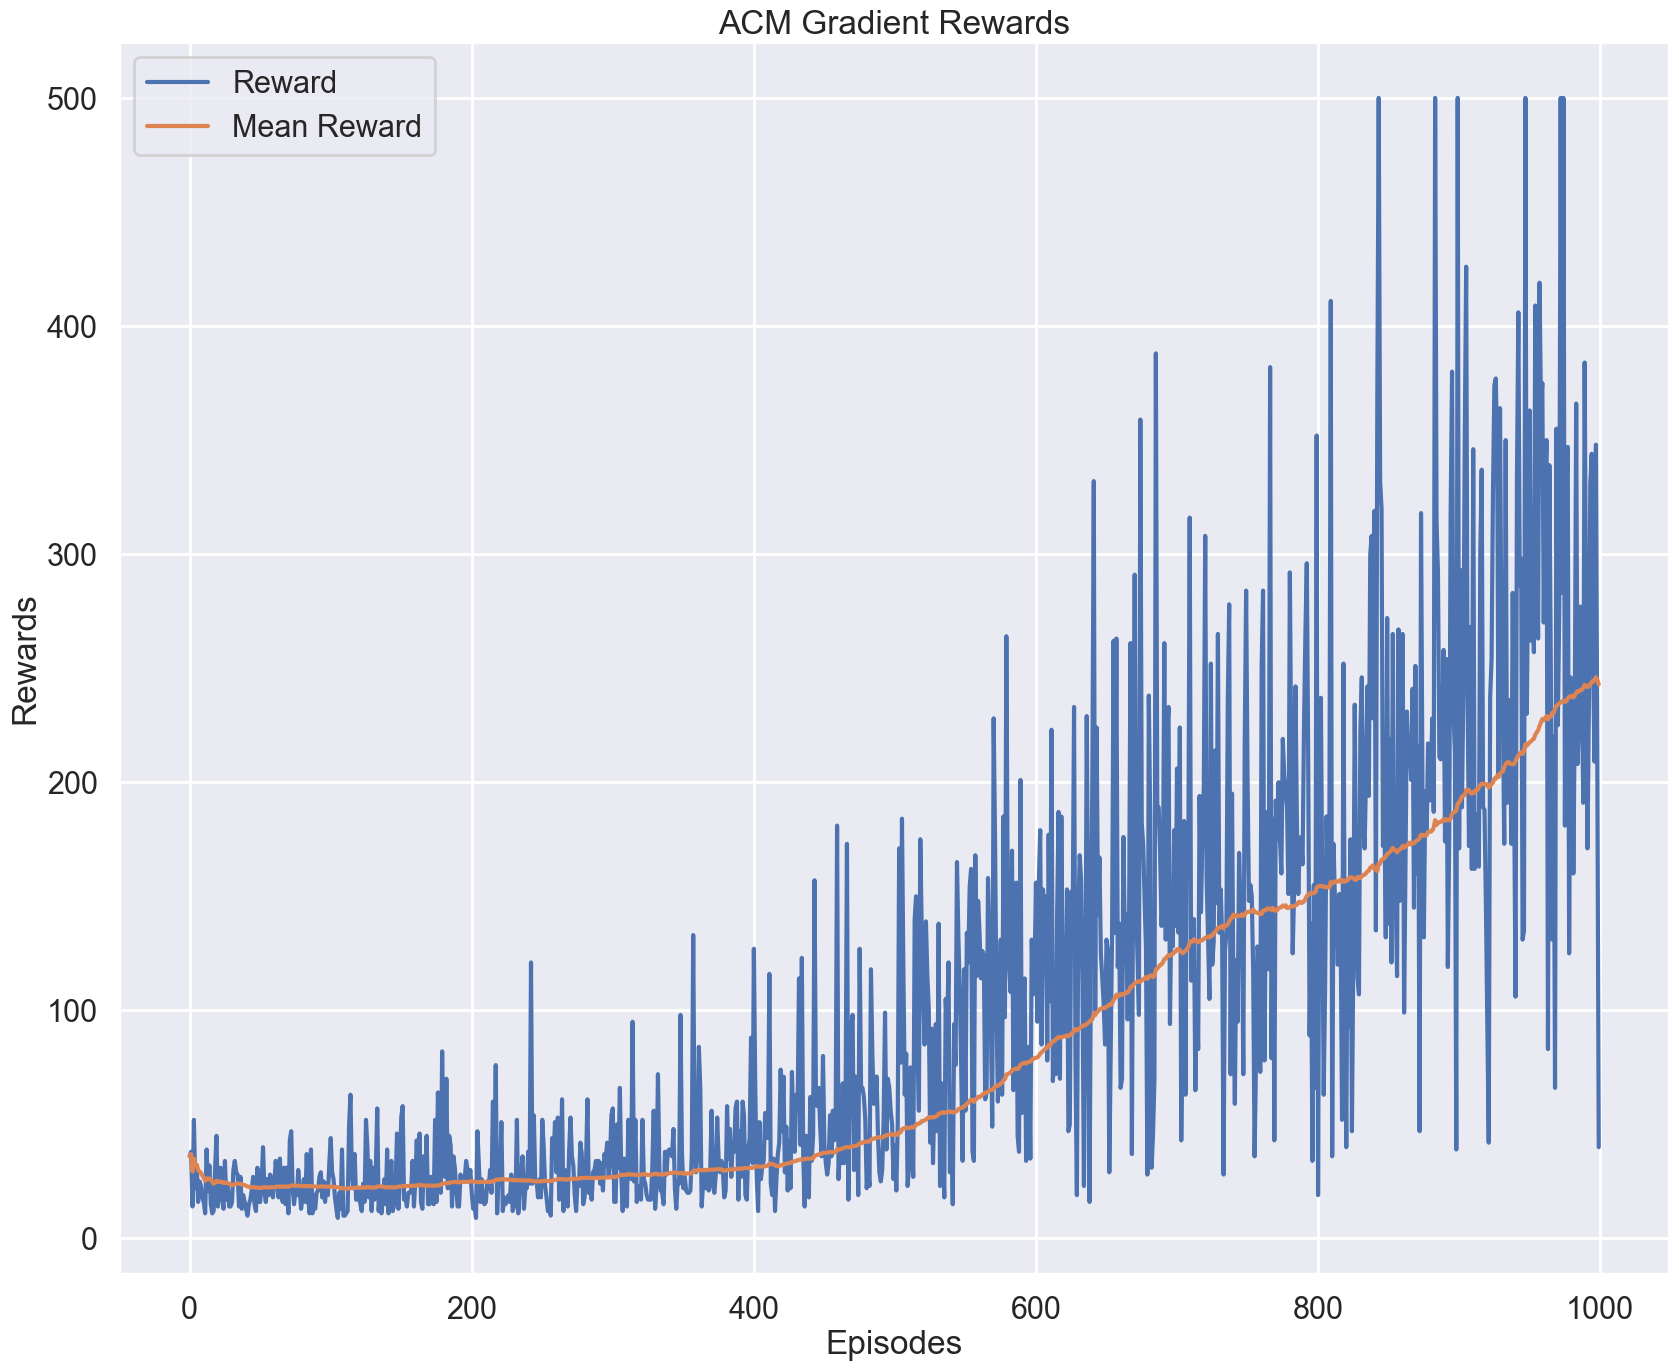

In [25]:
if __name__ == "__main__":
    main()